In [1]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [2]:
df = pd.read_excel("Sample - Superstore.xls")
furniture = df.loc[df['Category'] == 'Furniture']

In [3]:
furniture['Order Date'].min(), furniture['Order Date'].max()

(Timestamp('2014-01-06 00:00:00'), Timestamp('2017-12-30 00:00:00'))

# Data Preprocessing

In [4]:
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
furniture.drop(cols, axis=1, inplace=True)
furniture = furniture.sort_values('Order Date')
furniture.isnull().sum()

Order Date    0
Sales         0
dtype: int64

In [5]:
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()

# Indexing with time series data

In [6]:
furniture = furniture.set_index('Order Date')
furniture.index

DatetimeIndex(['2014-01-06', '2014-01-07', '2014-01-10', '2014-01-11',
               '2014-01-13', '2014-01-14', '2014-01-16', '2014-01-19',
               '2014-01-20', '2014-01-21',
               ...
               '2017-12-18', '2017-12-19', '2017-12-21', '2017-12-22',
               '2017-12-23', '2017-12-24', '2017-12-25', '2017-12-28',
               '2017-12-29', '2017-12-30'],
              dtype='datetime64[ns]', name='Order Date', length=889, freq=None)

In [7]:
y = furniture['Sales'].resample('MS').mean()

In [8]:
# 2017 furniture sales data
y['2017':]

Order Date
2017-01-01     397.602133
2017-02-01     528.179800
2017-03-01     544.672240
2017-04-01     453.297905
2017-05-01     678.302328
2017-06-01     826.460291
2017-07-01     562.524857
2017-08-01     857.881889
2017-09-01    1209.508583
2017-10-01     875.362728
2017-11-01    1277.817759
2017-12-01    1256.298672
Freq: MS, Name: Sales, dtype: float64

# Visualising furniture sales time series data

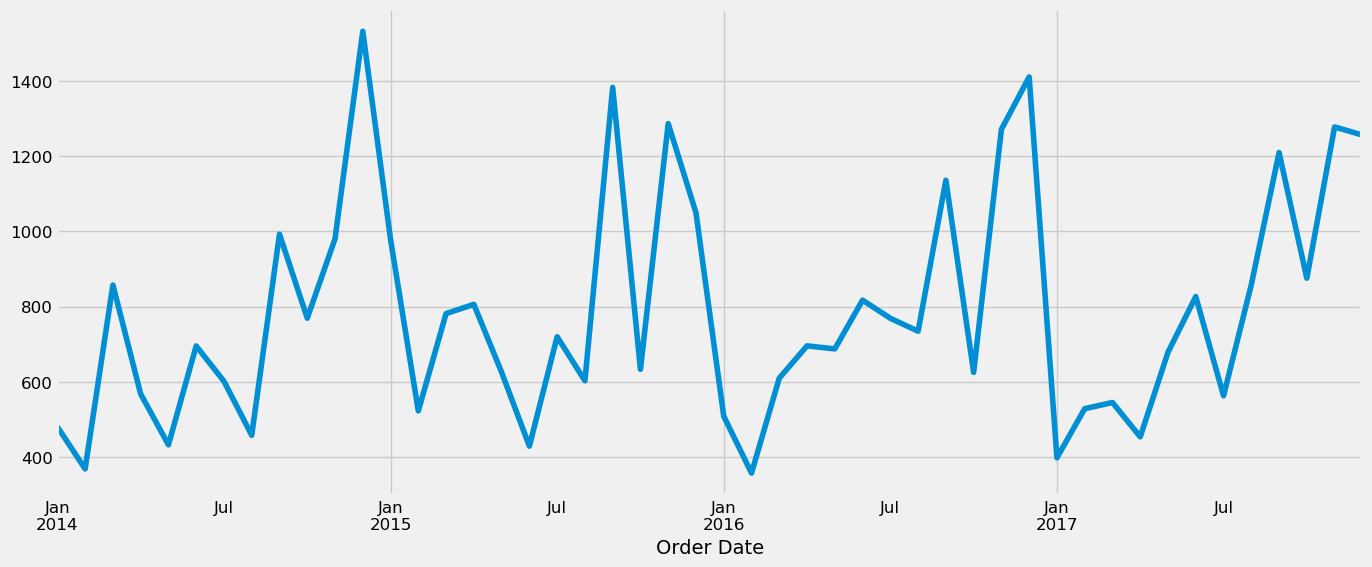

In [9]:
y.plot(figsize=(15, 6))
plt.show()
#The time-series has seasonality pattern, such as sales are always low at the beginning of the year and high at the end of the year. 
#There is always an upward trend within any single year with a couple of low months in the mid of the year.

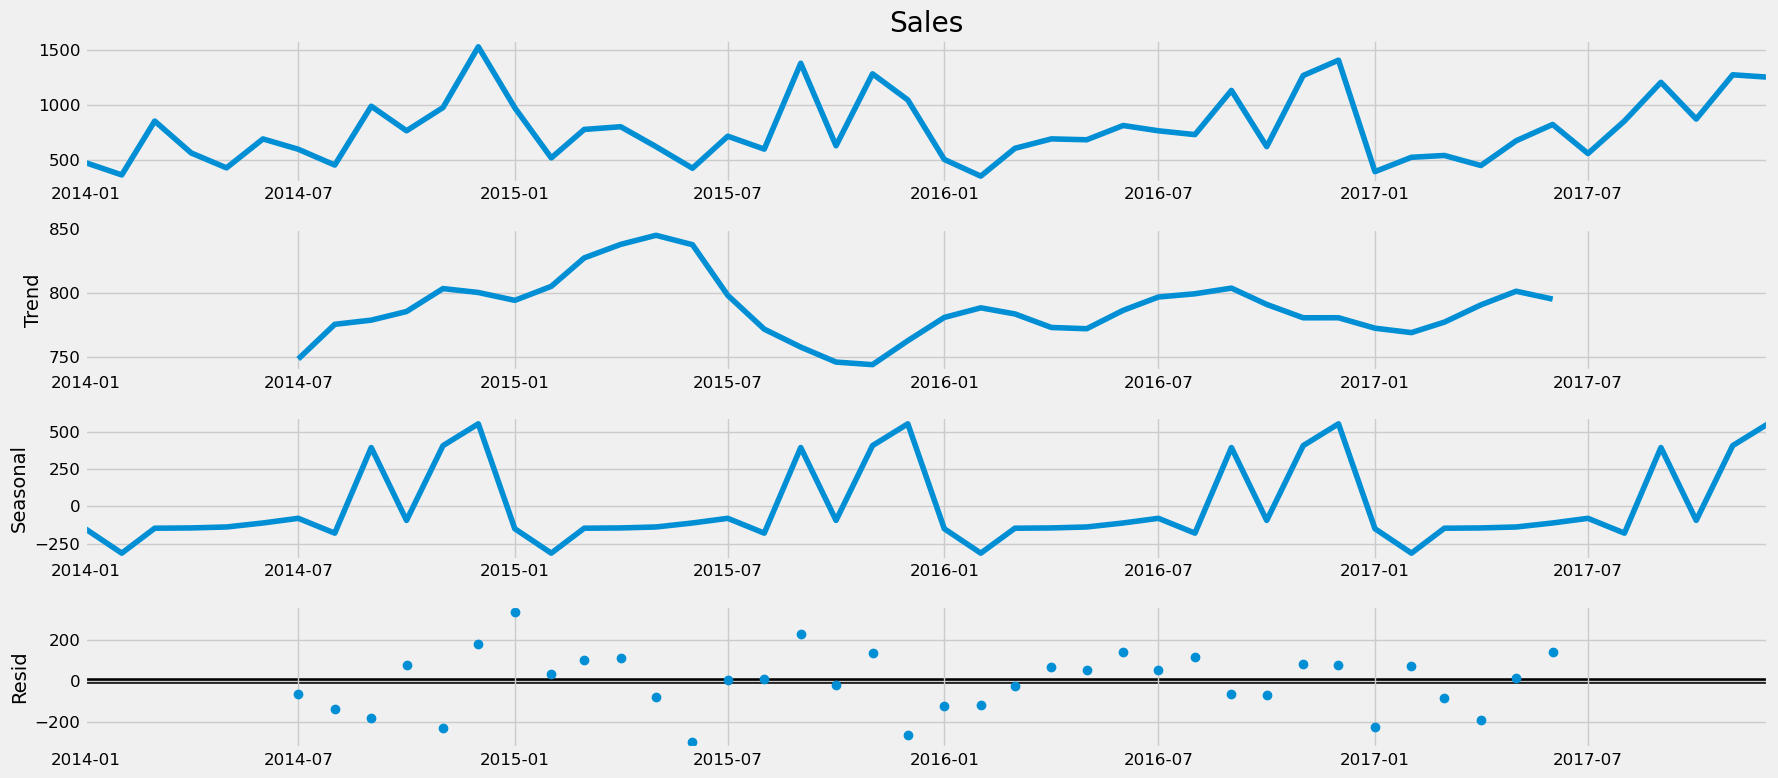

In [10]:
# We can also visualize our data using a method called time-series decomposition
# it allows us to decompose our time series into three distinct components: trend, seasonality, and noise.
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()
# The plot above clearly shows that the sales of furniture is unstable, along with its obvious seasonality.

In [11]:
from statsmodels.tsa.stattools import adfuller

ad_fuller_result = adfuller(y)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -5.1910701873392755
p-value: 9.16875665566545e-06


The given Time Series is Stationary as:

1.ADF Statistics Value is Negative

2.P-Value is Less than 0.05

Therefeore, this statisfies the Alternate Hypothesis of ADF Test-No Unit Root Exists, Time Series is Stationary

In [12]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


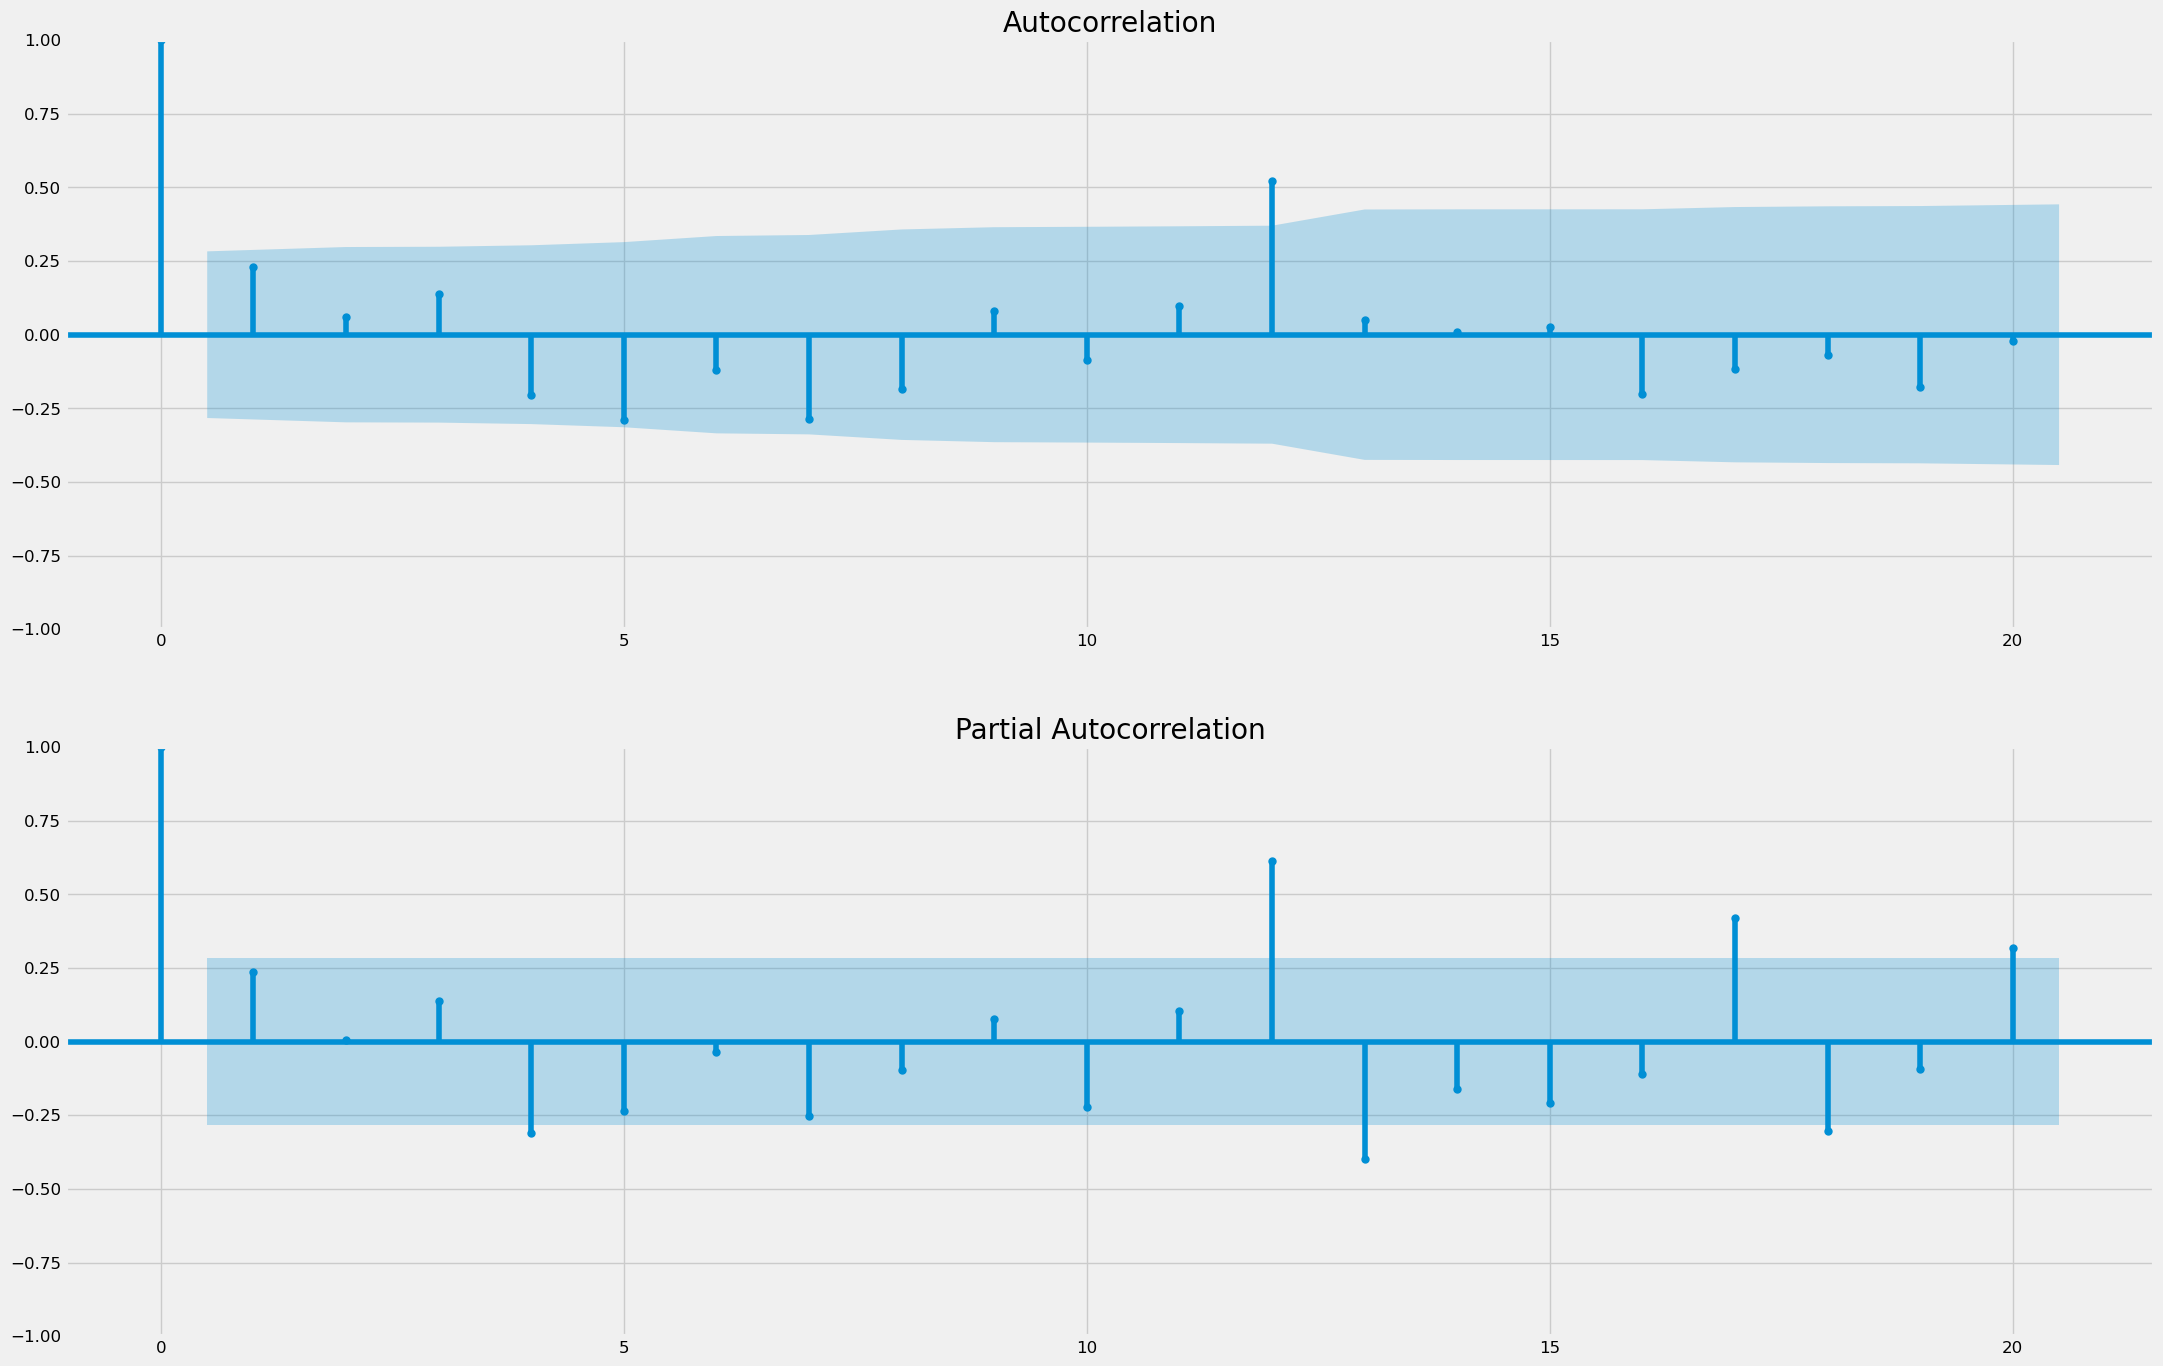

In [13]:
fig = plt.figure(figsize=(24,16))
ax1 = fig.add_subplot(211)
fig = plot_acf(y.values.squeeze(), lags=20, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(y, lags=20, ax=ax2)

# Time series forecasting with ARIMA

In [14]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [15]:
# using grid search to get optimised parameters
results = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,order=param,seasonal_order=param_seasonal)
            model= mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, model.aic))
        except:
            continue
        aic = model.aic
        results.append([param,param_seasonal, model.aic])
        
result_df = pd.DataFrame(results,columns=['param','seasonal','AIC'])
result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)


ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:784.7193402038779
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:751.4084265540198
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:495.3709027489218
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:489.8305340055072
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:691.7786646550559
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:686.6126556822222
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:491.25398194267945
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:491.80965161276134
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:751.0635462734376
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:724.1781113537791
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:497.0445558712977
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:491.664077124134
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:689.6572888675329


C:\Users\aksha\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:685.0832256911879
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:493.1979865789047


C:\Users\aksha\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:493.6293896969338
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:691.6686053888744
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:680.9066784724719
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:501.19171493703334
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:498.2211751124292
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:672.7905898083391
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:674.3395295975504
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:500.10704742506397
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:500.0205243521985
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:679.3885628125779
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:667.5163726623847
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:489.64305357981385
ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:482.83257313196657
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:656.5174597025102
ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:652.2674701391138
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:484.71190424687506
ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:484.8280780840741
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:707.8812143775962
ARIMA

C:\Users\aksha\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:681.1993934487693
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:493.18796239422346


C:\Users\aksha\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:493.60744917351644
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:697.3492691538816
ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:684.5282217849502
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:498.85275545567845
ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:493.557463533031


C:\Users\aksha\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:673.2906693588293
ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:669.370086414491
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:495.082667080061


C:\Users\aksha\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:495.52786017083685
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:684.9765838986987
ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:673.722555680521
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:494.3112171937179
ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:490.62427514875884
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:665.2664123034144
ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:665.1114320253331
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:491.85420116840413


C:\Users\aksha\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:492.57547043278225
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:678.441888546263
ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:666.0577882113479
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:490.87917258657137
ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:484.5938796678005
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:656.534405128362
ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:653.3743572233126
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:486.56325343525907
ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:486.5823540241306


In [16]:
result_df

,param,seasonal,AIC
0,"(0, 1, 1)","(0, 1, 1, 12)",482.832573
1,"(1, 1, 1)","(0, 1, 1, 12)",484.593880
2,"(0, 1, 1)","(1, 1, 0, 12)",484.711904
3,"(0, 1, 1)","(1, 1, 1, 12)",484.828078
4,"(1, 1, 1)","(1, 1, 0, 12)",486.563253
...,...,...,...
59,"(1, 0, 0)","(0, 0, 0, 12)",707.881214
60,"(0, 0, 1)","(0, 0, 1, 12)",724.178111
61,"(0, 0, 1)","(0, 0, 0, 12)",751.063546
62,"(0, 0, 0)","(0, 0, 1, 12)",751.408427


In [18]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(0, 1, 1),
                                seasonal_order=(0, 1, 1, 12))
results = mod.fit()

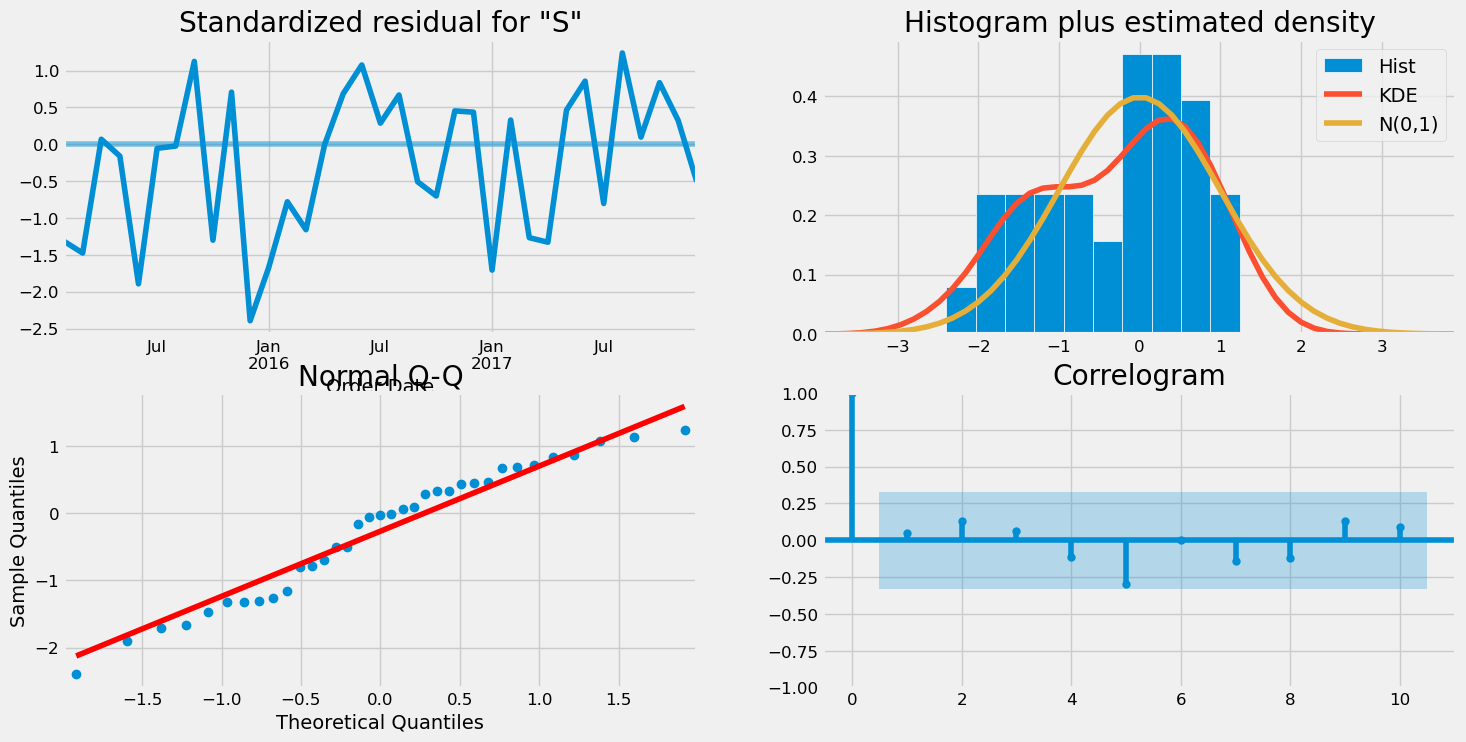

In [19]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

# Validating forecasts

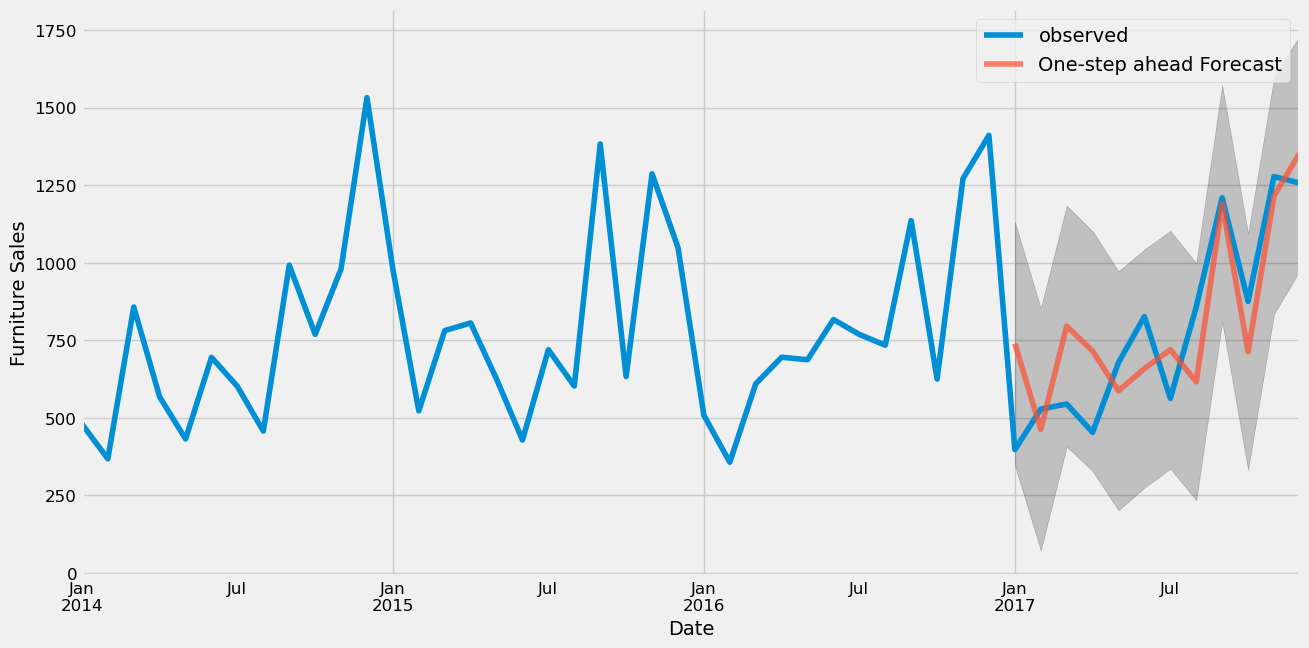

In [20]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

In [21]:
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 34361.46


In [22]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 185.37


# Producing and visualizing forecasts

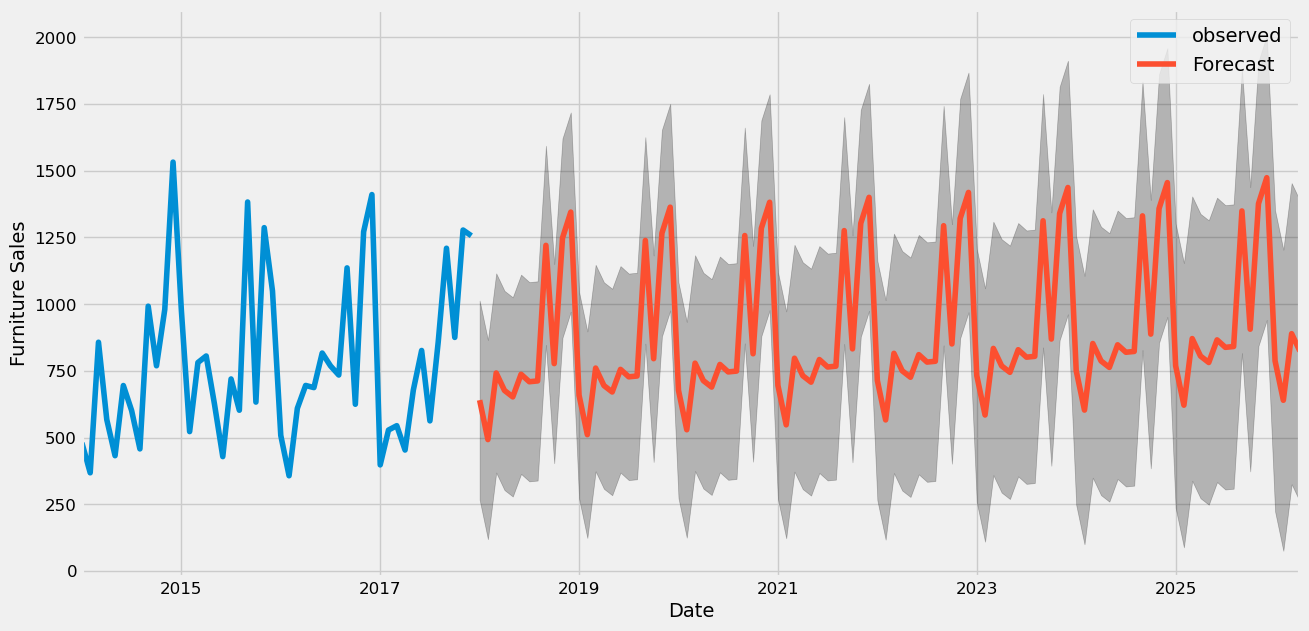

In [23]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()
# Our model clearly captured furniture sales seasonality